# Turing.jl: Beyond the basics

In this notebook we'll explore some slightly more complicated models and features of Turing.jl.


The materials for this afternoon can be found at [github.com/TuringLang/Turing-Workshop/tree/main/2025-CFE-CMStatistics](https://github.com/TuringLang/Turing-Workshop/tree/main/2025-CFE-CMStatistics). This notebook is the part 2.

NOTE: This notebook has been tested with Julia v1.11 and Turing v0.42. It should be equally fine on Julia v1.12 or v1.10, except for one cell at the bottom that uses Enzyme, and doesn't work on v1.12.

## Differential equations

We'll start with showing how to do Bayesian inferences for the parameters of a differential equations. Our case study this time won't be made up fake data, but rather a historical case of an epidemic in a boarding school.

We'll work with an outbreak of influenza A (H1N1) in 1978 at a British boarding school

-   763 male students -> 512 of which became ill
-   Reported that one infected boy started the epidemic
-   Observations are number of boys in bed over 14 days

Data are freely available in the R package `outbreaks`, maintained as part of the [R Epidemics Consortium](http://www.repidemicsconsortium.org/). It's also in the same folder as this notebook, over at [github.com/TuringLang/Turing-Workshop/tree/main/2025-CFE-CMStatistics/part2](https://github.com/TuringLang/Turing-Workshop/tree/main/2025-CFE-CMStatistics/part2), as a CSV file.

Data + part of the analysis is *heavily* inspired by [https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html](https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html)

First, the familiar activating the local environment and installing packages.

In [2]:
import Pkg
Pkg.activate(".")

  Activating new project at `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/part2`


In [3]:
Pkg.add([
    "ADTypes",
    "CSV",
    "DataFrames",
    "Dates",
    "DifferentialEquations",
    "Distributions",
    "Enzyme",
    "Mooncake",
    "Plots",
    "ReverseDiff",
    "SciMLSensitivity",
    "StatsFuns",
    "StatsPlots",
    "Turing",
])

   Resolving package versions...
   Installed Mooncake ─ v0.4.183
    Updating `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/part2/Project.toml`
  [47edcb42] + ADTypes v1.20.0
  [336ed68f] + CSV v0.10.15
  [a93c6f00] + DataFrames v1.8.1
  [0c46a032] + DifferentialEquations v7.17.0
  [31c24e10] + Distributions v0.25.122
  [7da242da] + Enzyme v0.13.108
  [da2b9cff] + Mooncake v0.4.183
  [91a5bcdd] + Plots v1.41.2
  [37e2e3b7] + ReverseDiff v1.16.1
  [1ed8b502] + SciMLSensitivity v7.90.0
  [4c63d2b9] + StatsFuns v1.5.2
  [f3b207a7] + StatsPlots v0.15.8
  [fce5fe82] + Turing v0.42.0
  [ade2ca70] + Dates v1.11.0
    Updating `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/part2/Manifest.toml`
  [47edcb42] + ADTypes v1.20.0
  [621f4979] + AbstractFFTs v1.5.0
  [80f14c24] + AbstractMCMC v5.10.0
  [7a57a42e] + AbstractPPL v0.13.6
  [1520ce14] + AbstractTrees v0.4.5
  [7d9f7c33] + Accessors v0.1.43
  [79e6a3ab] + Adapt v4.4.0
  [0bf59076] + AdvancedHMC v0.8.3
  [5b7e

### Loading data



In [4]:
# Load the dataframe.
using Dates
using DataFrames, CSV

N = 763
data = DataFrame(CSV.File("influenza_england_1978_school.csv"));
print(data)

14×4 DataFrame
 Row │ Column1  date        in_bed  convalescent 
     │ Int64    Date        Int64   Int64        
─────┼───────────────────────────────────────────
   1 │       1  1978-01-22       3             0
   2 │       2  1978-01-23       8             0
   3 │       3  1978-01-24      26             0
   4 │       4  1978-01-25      76             0
   5 │       5  1978-01-26     225             9
   6 │       6  1978-01-27     298            17
   7 │       7  1978-01-28     258           105
   8 │       8  1978-01-29     233           162
   9 │       9  1978-01-30     189           176
  10 │      10  1978-01-31     128           166
  11 │      11  1978-02-01      68           150
  12 │      12  1978-02-02      29            85
  13 │      13  1978-02-03      14            47
  14 │      14  1978-02-04       4            20

Notice that each of the columns have associated types. We'll be interested in the `in_bed` column which we take as a proxy for how many people are currently ill and infectious.

Let's visualize the samples:

In [5]:
using StatsPlots

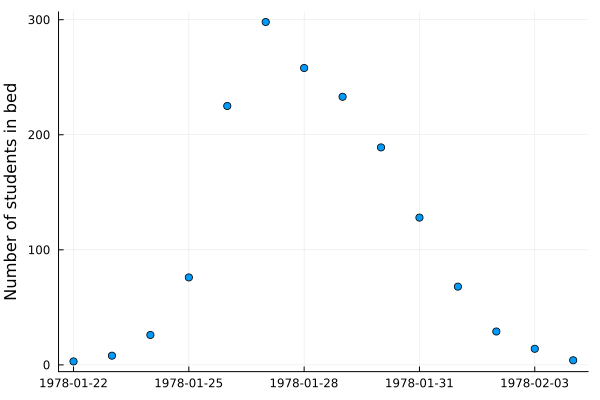

In [ ]:
scatter(data[:,:date], data[:,:in_bed], label=nothing, ylabel="Number of students in bed")

### The SIR model



We'll model this epidemic using the SIR model, which has three variables describing the spread of infection in the population:

![img](2023-01-19_19-56-00_sir_illu.png "[https://covid19.uclaml.org/model.html>](https://covid19.uclaml.org/model.html>)(2023-01-19)")

The temporal dynamics of the sizes of each of the compartments are governed by the following system of ordinary differential equations:

\begin{equation*}
\begin{split}
  \frac{\mathrm{d} S}{\mathrm{d} t} &= - \beta S \frac{I}{N} \\
  \frac{\mathrm{d} I}{\mathrm{d} t} &= \beta S \frac{I}{N} - \gamma I \\
  \frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I
\end{split}
\end{equation*}

where

-   $S(t)$ is the number of people susceptible to becoming infected,
-   $I(t)$ is the number of people currently infected,
-   $R(t)$ is the number of recovered people,
-   $β$ is the constant rate of infectious contact between people,
-   $\gamma$ the constant recovery rate of infected individuals

Converting this ODE into code is just



In [7]:
using DifferentialEquations

function sir!(
    du,  # buffer for the updated differential equation
    u,   # current state
    p,   # parameters
    t,   # current time
)
    N = 763  # population
    S, I, R = u
    β, γ = p

    du[1] = dS = -β * I * S / N
    du[2] = dI = β * I * S / N - γ * I
    du[3] = dR = γ * I
end

sir! (generic function with 1 method)

Initial conditions are then

\begin{equation*}
\begin{split}
  S(0) &= N - 1 \\
  I(0) &= 1 \\
  R(0) &= 0
\end{split}
\end{equation*}

and we want to integrate from $t = 0$ to $t = 14$



In [8]:
# Include 0 because that's the initial condition before any observations.
tspan = (0.0, 14.0)

# Initial conditions are:
#   S(0) = N - 1; I(0) = 1; R(0) = 0
u0 = [N - 1, 1, 0]

3-element Vector{Int64}:
 762
   1
   0

Now we just need to define the overall problem and we can solve:



In [9]:
# Just to check that everything works, we'll just use some "totally random" values for β and γ:
problem_sir = let β = 2.0, γ = 0.6
    ODEProblem(sir!, u0, tspan, (β, γ))
end

ODEProblem with uType Vector{Int64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 14.0)
u0: 3-element Vector{Int64}:
 762
   1
   0

In [10]:
sol = solve(problem_sir)

retcode: Success
Interpolation: 3rd order Hermite
t: 23-element Vector{Float64}:
  0.0
  0.0023558376404244326
  0.025914214044668756
  0.11176872847552288
  0.26714420197833877
  0.476535832034061
  0.7436980957344042
  1.070118235536993
  1.455669519603104
  1.8994814798521351
  ⋮
  5.234036349443436
  6.0731320824295665
  7.323851092945656
  8.231007104834719
  9.660468959151524
 11.027716920177943
 12.506966480202824
 13.988902571015888
 14.0
u: 23-element Vector{Vector{Float64}}:
 [762.0, 1.0, 0.0]
 [761.9952867607622, 1.003297407481751, 0.001415831756055325]
 [761.9472927630898, 1.036873767352754, 0.015833469557440357]
 [761.7584189584999, 1.1690001124313594, 0.0725809290687477]
 [761.353498624185, 1.4522140040481546, 0.19428737176676508]
 [760.6490370431834, 1.944782026374286, 0.4061809304422879]
 [759.3950817030517, 2.821076701235591, 0.783841595712662]
 [757.0795802792126, 4.4375639540504945, 1.4828557667369016]
 [752.6094757149726, 7.552144925439609, 2.838379359587775]
 [743.

Here we used the default ODE solver from DifferentialEquations.jl (which serves us just fine), but note that there are _many_ options for solvers available: [https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/)

Let's plot the solution

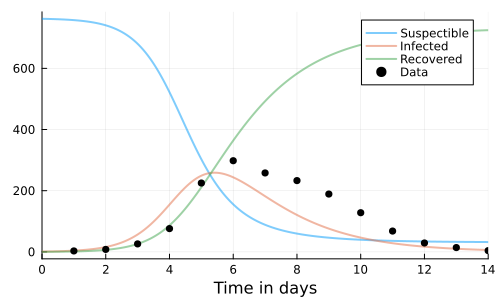

In [11]:
p = plot(
    sol,
    linewidth=2, xaxis="Time in days", label=["Suspectible" "Infected" "Recovered"],
    alpha=0.5, size=(500, 300)
)
scatter!(p, 1:14, data.in_bed, label="Data", color="black")

That's of course just plotting a solution for some example values of β and γ. Let's do some proper inference instead.



### Turing.jl model for SIR

In [12]:
using Turing

We'll use the following model, which someone far wiser than me (and knowledgeable on epidemiology) has given us:

\begin{equation*}
\begin{split}
  \beta &\sim \mathcal{N}_{ + }(1, 1) \\
  \gamma &\sim \mathrm{Beta}(2, 5) \\
  \phi^{-1} &\sim \mathrm{Exponential}(1/5) \\
   y_i &\sim \mathrm{NegativeBinomial2}\big(F(u_0, t_i;\ \beta, \gamma), \phi \big)
\end{split}
\end{equation*}

where 

-   $\big( y_i \big)_{i = 1}^{14}$ are the observations,
-   $F$ is the integrated system, and
-   $\phi$ is the over-dispersion parameter.



Please don't ask me to explain why these are good priors. If you are interested though, there's a more extensive version of this tutorial [here](https://github.com/TuringLang/Turing-Workshop/tree/main/2023-Geilo-Winter-School/Part-2-Turing-and-other-things).
That one goes through first making a guess at the priors, then doing prior predictive checks and improving the priors.

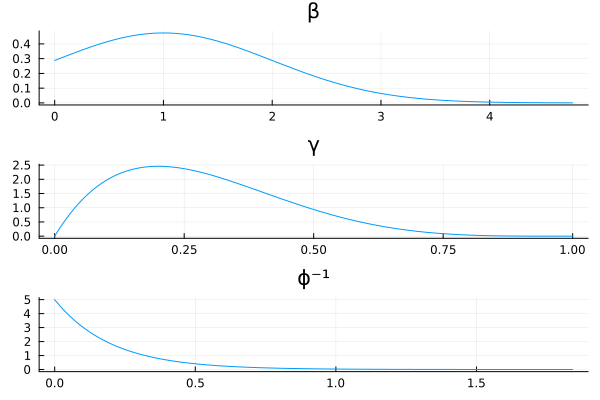

In [13]:
plot(
    plot(truncated(Normal(1, 1); lower=0), label=nothing, title="β"),
    plot(Beta(2, 5), label=nothing, title="γ"),
    plot(Exponential(1/5), label=nothing, title="ϕ⁻¹"),
    layout=(3, 1)
)

A `NegativeBinomial(r, p)` represents the number of trials to achieve $r$ successes, where each trial has a probability $p$ of success.

A `NegativeBinomial2(μ, ϕ)` is the same, but parameterized using the mean $μ$ and dispersion $\phi$.

In [14]:
# `NegativeBinomial` already exists, so let's just make an alternative constructor instead.
function NegativeBinomial2(μ, ϕ)
    p = 1/(1 + μ/ϕ)
    if p > one(p)
        p = p * (1 - 1e-5)
    end
    r = ϕ
    return NegativeBinomial(r, p)
end

NegativeBinomial2 (generic function with 1 method)

Putting all this into a Turing.jl model:



In [ ]:
@model function sir_model(
    num_days;                                  # Number of days to model
    tspan = (0.0, float(num_days)),            # Timespan to model
    u0 = [N - 1, 1, 0.0],                      # Initial state
    p0 = [2.0, 0.6],                           # Placeholder parameters
    problem = ODEProblem(sir!, u0, tspan, p0)  # Create problem once so we can `remake`.
)
    β ~ truncated(Normal(1, 1); lower=0)
    γ ~ Beta(2, 5)
    ϕinv ~ Exponential(1/5)
    ϕ = inv(ϕinv)
    # Like ODEProblem(sir!, u0, tspan, [β, γ]) but avoids memory
    # allocations by recycling an existing ODEProblem.
    problem_new = remake(problem, p=[β, γ])  # Replace parameters `p`.
    # saveat=1 says that we only want sol to include values for time steps of 1,
    # corresponding to full days.
    sol = solve(problem_new, saveat=1)       # Solve!

    if !SciMLBase.successful_retcode(sol)
        @addlogprob! -Inf  # NOTE: Causes automatic rejection.
        return nothing
    end

    sol_for_observed = sol[2, 2:num_days + 1]  # Timesteps we have observations for.
    in_bed = Vector{Int}(undef, num_days)
    for i in 1:length(sol_for_observed)
        # The argument to NegativeBinomial2, f, must be 0 < f <= 1.
        # We enforce this by adding a tiny constant to it (to guard against values slightly below 0)
        # and rejecting this sample if it's larger than 1.
        f = sol_for_observed[i] + 1e-5
        # Add a small constant to `sol_for_observed` to make things more stable.
        in_bed[i] ~ NegativeBinomial2(f, ϕ)
    end
end

sir_model (generic function with 2 methods)

In [16]:
model = sir_model(length(data.in_bed))
model_conditioned = model | (; in_bed = data.in_bed,)

DynamicPPL.Model{typeof(sir_model), (:num_days,), (:tspan, :u0, :p0, :problem), (), Tuple{Int64}, Tuple{Tuple{Float64, Float64}, Vector{Float64}, Vector{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(sir!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}}, DynamicPPL.ConditionContext{@NamedTuple{in_bed::Vector{Int64}}, DynamicPPL.DefaultContext}, false}(Main.sir_model, (num_days = 14,), (tspan = (0.0, 14.0), u0 = [762.0, 1.0, 0.0], p0 = [2.0, 0.6], problem = ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(sir!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing

### Inference



Yet again, we sample from the posterior using NUTS, doing a few chains in parallel.

In [17]:
chain = sample(model_conditioned, NUTS(), MCMCThreads(), 2_000, 4; progress=false)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/mhauru/.julia/packages/AbstractMCMC/mcqES/src/sample.jl:432
┌ Info: Found initial step size
│   ϵ = 0.2015625
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222


Chains MCMC chain (2000×17×4 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 4
Samples per chain = 2000
Wall duration     = 19.64 seconds
Compute duration  = 17.29 seconds
parameters        = β, γ, ϕinv
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, logprior, loglikelihood, logjoint

Use `describe(chains)` for summary statistics and quantiles.


The summary statistics look pretty good: Effective sample size (ESS) is relatively high, Rhat close to 1.

In [18]:
describe(chain)

Chains MCMC chain (2000×17×4 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 4
Samples per chain = 2000
Wall duration     = 19.64 seconds
Compute duration  = 17.29 seconds
parameters        = β, γ, ϕinv
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, logprior, loglikelihood, logjoint

Summary Statistics

  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           β    1.7286    0.0535    0.0007   6075.7687   5209.9898    1.0008   ⋯
           γ    0.5300    0.0425    0.0005   6247.8298   4734.0904    1.0006   ⋯
        ϕinv    0.1351    0.0740    0.0010   5081.8486   4236.0455    1.0002   ⋯

                                                                1 column omitted

Quantiles

  parameters    

Trace plots also look good, and the four chains have produced similar posterior distributions:

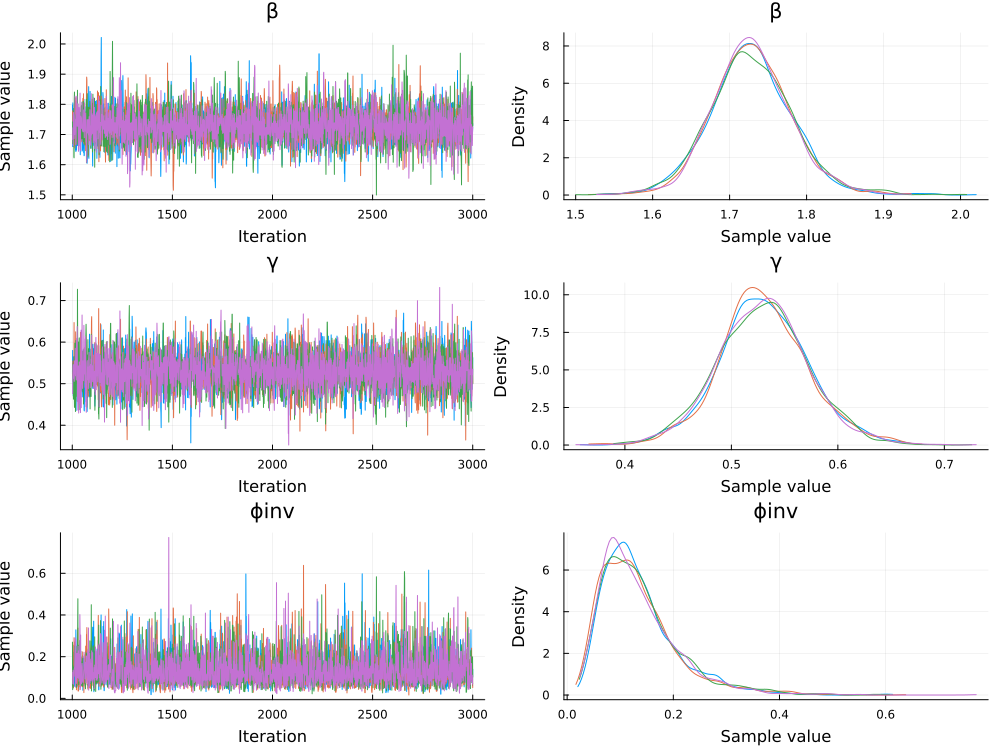

In [19]:
plot(chain)

Let's also do a quick posterior predictive check, by sampling predictions for the data from our posterior, and then plotting the 10%, 50%, and 90% quantiles for what sort of data this posterior typically generates:

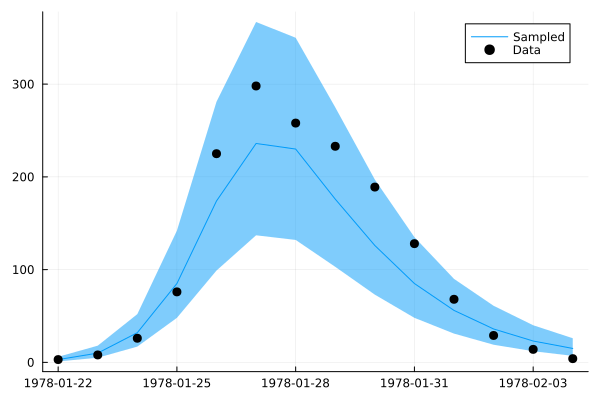

In [20]:
model_unconditioned = decondition(model_conditioned, :in_bed)
predictive_check = predict(model_unconditioned, chain)
qs = quantile(predictive_check; q=[0.10, 0.5, 0.90])
lower = qs[:, Symbol("10.0%")]
median = qs[:, Symbol("50.0%")]
upper = qs[:, Symbol("90.0%")]
p = plot()
p = plot!(p, data[:,:date], median; ribbon=(median .- lower, upper .- median), label="Sampled")
p = scatter!(p, data[:,:date], data[:,:in_bed]; label="Data", markersize=5, markercolor=:black)
p

The source data seems quite plausible in the light of this posterior. I'd call that a success!

## Going big(ger)

At this point, you may fairly complain that all our demo models have been very small in their dimensionality. This is most definitely true. I won't go into detail about some complicated, big model, but I do want to highlight at least one aspect of working with them.

To have something to work with for demonstration, imagine you have this model:

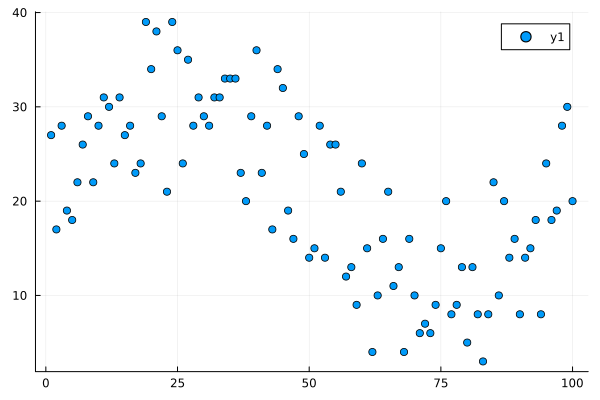

In [21]:
@model function my_big_model(num_parameters)
    p = Vector{Float64}(undef, num_parameters)
    p[1] ~ truncated(Normal(0, 100); lower=0)
    for i in 2:num_parameters
        p[i] ~ truncated(Normal(p[i-1], 1); lower=0)
    end
    observation ~ product_distribution(Poisson.(p))
end

num_parameters = 100
noise_level = 20
data = ceil.(10 * (sin.((2 * pi / num_parameters) .* (1:num_parameters)) .+ 1) .+ rand(num_parameters) * noise_level)
scatter(data)

It's a bit of non-sense, but you can imagine it being a stand-in for some sort of time series process, where you have a random walk of parameters `p`, and they produce observations at each step. It doesn't matter too much, the main point is that this model has a 100 parameters that need to be sampled. Let's do a bit of sampling:

In [22]:
big_model = my_big_model(num_parameters) | (; observation=data)
num_samples = 1000
big_chain = sample(big_model, NUTS(), num_samples; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222


Chains MCMC chain (1000×114×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 33.54 seconds
Compute duration  = 33.54 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12], p[13], p[14], p[15], p[16], p[17], p[18], p[19], p[20], p[21], p[22], p[23], p[24], p[25], p[26], p[27], p[28], p[29], p[30], p[31], p[32], p[33], p[34], p[35], p[36], p[37], p[38], p[39], p[40], p[41], p[42], p[43], p[44], p[45], p[46], p[47], p[48], p[49], p[50], p[51], p[52], p[53], p[54], p[55], p[56], p[57], p[58], p[59], p[60], p[61], p[62], p[63], p[64], p[65], p[66], p[67], p[68], p[69], p[70], p[71], p[72], p[73], p[74], p[75], p[76], p[77], p[78], p[79], p[80], p[81], p[82], p[83], p[84], p[85], p[86], p[87], p[88], p[89], p[90], p[91], p[92], p[93], p[94], p[95], p[96], p[97], p[98], p[99], p[100]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, ha

Just for fun, here's the posterior inferred for the underlying random walk:

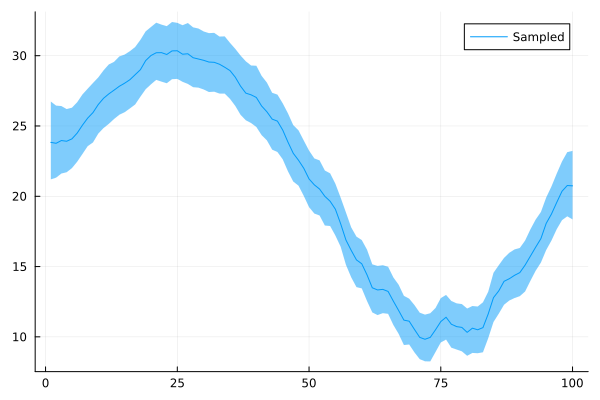

In [23]:
qs = quantile(big_chain; q=[0.10, 0.5, 0.90])
lower = qs[:, Symbol("10.0%")]
median = qs[:, Symbol("50.0%")]
upper = qs[:, Symbol("90.0%")]
plot(median; ribbon=(median .- lower, upper .- median), label="Sampled")

How might one speed this up? One thing we haven't talked about at all so far, is that NUTS and HMC require you to be able to evaluate not just the model with a given set of parameters, and get the log probability, but also the _gradient_ of the log probability at those parameter values. How does that happen?

The answer is automatic differentiation. Its beauty is of course the "automatic" part: We've been merrily sampling from different kinds of models this afternoon without ever having to worry about it. We even solved some differential equations, and differentiated through that process without any issues. That's pretty cool!

By default Turing uses the [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) package to do automatic differentiation. It's reliable and battle-tested. But for large models it can be quite slow. So for larger models like above, you may want to try switching to something faster, something that does reverse-mode automatic differentiation. The old-fashioned choice is [ReverseDiff.jl](https://github.com/JuliaDiff/ReverseDiff.jl), the emerging new go-to standard is [Mooncake.jl](https://github.com/chalk-lab/Mooncake.jl), and the fastest but still a bit rough around the edges one is [Enzyme.jl](https://github.com/EnzymeAD/Enzyme.jl). Turing.jl can work with any of them, although not all of them support everything you can possibly do within `@model`. We keep a comparison of the various options, applied to various models, here: https://turinglang.org/ADTests/

Here's how you could use Mooncake:

To have a fair point of comparison, let's run the above sampling again. This time I've specified the usage of ForwardDiff explicitly, but it's the default anyway, so this is exactly what we ran before. The reason to run it again is that on the first go Julia needs to compile some of the functions, which creates an overhead. Only on the second go do you get an idea of how fast the sampling itself is.

In [24]:
sample(big_model, NUTS(; adtype=AutoForwardDiff()), num_samples; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222


Chains MCMC chain (1000×114×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 29.33 seconds
Compute duration  = 29.33 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12], p[13], p[14], p[15], p[16], p[17], p[18], p[19], p[20], p[21], p[22], p[23], p[24], p[25], p[26], p[27], p[28], p[29], p[30], p[31], p[32], p[33], p[34], p[35], p[36], p[37], p[38], p[39], p[40], p[41], p[42], p[43], p[44], p[45], p[46], p[47], p[48], p[49], p[50], p[51], p[52], p[53], p[54], p[55], p[56], p[57], p[58], p[59], p[60], p[61], p[62], p[63], p[64], p[65], p[66], p[67], p[68], p[69], p[70], p[71], p[72], p[73], p[74], p[75], p[76], p[77], p[78], p[79], p[80], p[81], p[82], p[83], p[84], p[85], p[86], p[87], p[88], p[89], p[90], p[91], p[92], p[93], p[94], p[95], p[96], p[97], p[98], p[99], p[100]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, ha

Here's the same thing but using Mooncake. First, a few samples to get the compilation done.

In [25]:
# Let's try Mooncake instead. Run a few samples just to get compilation out of the way.
import Mooncake
sample(big_model, NUTS(; adtype=AutoMooncake(; config=nothing)), 5; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222


Chains MCMC chain (5×114×1 Array{Float64, 3}):

Iterations        = 3:1:7
Number of chains  = 1
Samples per chain = 5
Wall duration     = 51.03 seconds
Compute duration  = 51.03 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12], p[13], p[14], p[15], p[16], p[17], p[18], p[19], p[20], p[21], p[22], p[23], p[24], p[25], p[26], p[27], p[28], p[29], p[30], p[31], p[32], p[33], p[34], p[35], p[36], p[37], p[38], p[39], p[40], p[41], p[42], p[43], p[44], p[45], p[46], p[47], p[48], p[49], p[50], p[51], p[52], p[53], p[54], p[55], p[56], p[57], p[58], p[59], p[60], p[61], p[62], p[63], p[64], p[65], p[66], p[67], p[68], p[69], p[70], p[71], p[72], p[73], p[74], p[75], p[76], p[77], p[78], p[79], p[80], p[81], p[82], p[83], p[84], p[85], p[86], p[87], p[88], p[89], p[90], p[91], p[92], p[93], p[94], p[95], p[96], p[97], p[98], p[99], p[100]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_e

And then the main course, getting 1000 samples:

In [26]:
sample(big_model, NUTS(; adtype=AutoMooncake(; config=nothing)), num_samples; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222


Chains MCMC chain (1000×114×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 4.35 seconds
Compute duration  = 4.35 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12], p[13], p[14], p[15], p[16], p[17], p[18], p[19], p[20], p[21], p[22], p[23], p[24], p[25], p[26], p[27], p[28], p[29], p[30], p[31], p[32], p[33], p[34], p[35], p[36], p[37], p[38], p[39], p[40], p[41], p[42], p[43], p[44], p[45], p[46], p[47], p[48], p[49], p[50], p[51], p[52], p[53], p[54], p[55], p[56], p[57], p[58], p[59], p[60], p[61], p[62], p[63], p[64], p[65], p[66], p[67], p[68], p[69], p[70], p[71], p[72], p[73], p[74], p[75], p[76], p[77], p[78], p[79], p[80], p[81], p[82], p[83], p[84], p[85], p[86], p[87], p[88], p[89], p[90], p[91], p[92], p[93], p[94], p[95], p[96], p[97], p[98], p[99], p[100]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hami

That's nearly 10 times faster than ForwardDiff, after you are done with the initial compilation.

Here's the same thing done with the other high-performance reverse mode automatic differentiation package, Enzyme:

NOTE: As of 2025-12-10 and Enzyme v0.13.109, the below doesn't work on Julia v1.12. If you are running Julia v1.12, Enzyme will error on this model. You can try switching to Julia v1.11, but frankly this isn't crucial for the notebook, so you can just move on.

In [27]:
import Enzyme
using ADTypes: AutoEnzyme
sample(big_model, NUTS(; adtype=AutoEnzyme(; function_annotation=Enzyme.Duplicated)), 5; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222


Chains MCMC chain (5×114×1 Array{Float64, 3}):

Iterations        = 3:1:7
Number of chains  = 1
Samples per chain = 5
Wall duration     = 19.56 seconds
Compute duration  = 19.56 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12], p[13], p[14], p[15], p[16], p[17], p[18], p[19], p[20], p[21], p[22], p[23], p[24], p[25], p[26], p[27], p[28], p[29], p[30], p[31], p[32], p[33], p[34], p[35], p[36], p[37], p[38], p[39], p[40], p[41], p[42], p[43], p[44], p[45], p[46], p[47], p[48], p[49], p[50], p[51], p[52], p[53], p[54], p[55], p[56], p[57], p[58], p[59], p[60], p[61], p[62], p[63], p[64], p[65], p[66], p[67], p[68], p[69], p[70], p[71], p[72], p[73], p[74], p[75], p[76], p[77], p[78], p[79], p[80], p[81], p[82], p[83], p[84], p[85], p[86], p[87], p[88], p[89], p[90], p[91], p[92], p[93], p[94], p[95], p[96], p[97], p[98], p[99], p[100]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_e

In [28]:
sample(big_model, NUTS(; adtype=AutoEnzyme(; function_annotation=Enzyme.Duplicated)), num_samples; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/Ak3CD/src/mcmc/hmc.jl:222


Chains MCMC chain (1000×114×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 6.29 seconds
Compute duration  = 6.29 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12], p[13], p[14], p[15], p[16], p[17], p[18], p[19], p[20], p[21], p[22], p[23], p[24], p[25], p[26], p[27], p[28], p[29], p[30], p[31], p[32], p[33], p[34], p[35], p[36], p[37], p[38], p[39], p[40], p[41], p[42], p[43], p[44], p[45], p[46], p[47], p[48], p[49], p[50], p[51], p[52], p[53], p[54], p[55], p[56], p[57], p[58], p[59], p[60], p[61], p[62], p[63], p[64], p[65], p[66], p[67], p[68], p[69], p[70], p[71], p[72], p[73], p[74], p[75], p[76], p[77], p[78], p[79], p[80], p[81], p[82], p[83], p[84], p[85], p[86], p[87], p[88], p[89], p[90], p[91], p[92], p[93], p[94], p[95], p[96], p[97], p[98], p[99], p[100]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hami

Likewise, we are on a whole different scale of performance than ForwardDiff. The advantage Mooncake and Enzyme have over ForwardDiff grows with the dimensionality of the model, so if you had 10,000 parameters rather than 1,000, the results would be even more drastic.

My personal rule of thumb for different automatic differentiation backends is

- Start with ForwardDiff (the default) while just developing the model and testing things, since it's the most robust.
- Once performance becomes an issue and you want to get serious, try Enzyme and Mooncake. Usually if Enzyme works it's the fastest. Usually if Enzyme doesn't work, Mooncake does. If even Mooncake doesn't work, you can consider ReverseDiff, or you may have to go back to ForwardDiff.

But really you should read https://turinglang.org/ADTests/ and benchmark.

The above timings are of course very crude. To do proper benchmarking we have a utility function at `Turing.DynamicPPL.TestUtils.AD.run_ad`. (We may make that part of the exported interface in the future.)